### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

### Data Transformation

In [2]:
# Compose: Chains multiple transformations together
transform = transforms.Compose([
    transforms.ToTensor(), # 0-255 -> [0,1]
    transforms.Normalize((0.5,),(0.5)) #[0,1] -> [-1,1]
])

train_data = datasets.MNIST(
    root="./data",
    train= True,
    transform= transform,
    download= True
)

test_data = datasets.MNIST(
    root="./data",
    train= False,
    transform= transform,
    download= True
)

In [3]:
len(train_data)

60000

In [4]:
len(test_data)

10000

#### DataLoader (Batching)

In [5]:
# batch_size=64: Load 64 images at a time (instead of all 60k at once - saves memory)
batch_size = 64

# becomes iterable object
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= True)

# Creates an iterator and fetches the first batch
# images: Tensor of shape [64, 1, 28, 28] (64 images, 1 channel (grayscale), 28×28 pixels)
# labels: Tensor of shape [64] containing digit labels (0-9)
data_iter = iter(train_loader)
images, labels = next(data_iter)

### Visualizing an Image

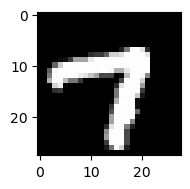

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(images[0].squeeze(), cmap="gray")
plt.tight_layout()
plt.show()

In [7]:
labels[0]

tensor(7)

### Train a Fully Connected Neural Network (FCNN)

In [8]:
# Creates a custom neural network
class DigitClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(    #Sequential:Container that runs layers in order
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            
        )

    def forward(self, x):
        return self.network(x)
    

In [9]:
# Instantiate the model, define loss function and optimizer
model = DigitClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optimizer.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()          # Zero the gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                # Backpropagate
        optimizer.step()               # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.3898
Epoch [2/5], Loss: 0.1914
Epoch [3/5], Loss: 0.1387
Epoch [4/5], Loss: 0.1138
Epoch [5/5], Loss: 0.0958


In [10]:
# Testing the model
model.eval()  # Switch to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 96.73%


### Classification Report & Confusion Matrix

In [11]:
# Testing the model
model.eval()  # Switch to evaluation mode

all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append labels and predictions to lists
        all_labels.extend(labels.numpy())    
        all_predicted.extend(predicted.numpy()) 

In [12]:
len(all_predicted)

10000

In [13]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.96      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predicted)
cm

array([[ 962,    0,    1,    1,    1,    1,    8,    1,    2,    3],
       [   0, 1121,    1,    3,    0,    1,    3,    2,    4,    0],
       [   4,    1, 1011,    3,    1,    2,    4,    4,    2,    0],
       [   0,    1,    6,  975,    0,   11,    0,    7,    5,    5],
       [   0,    0,    6,    0,  939,    0,    6,    6,    3,   22],
       [   4,    2,    0,   11,    2,  856,    8,    0,    4,    5],
       [   6,    2,    3,    1,    6,    3,  936,    0,    1,    0],
       [   0,    6,   15,    6,    0,    0,    0,  991,    3,    7],
       [   4,    2,    3,   20,    3,   12,    8,    2,  919,    1],
       [   3,    6,    2,   10,    7,    4,    2,    7,    5,  963]])

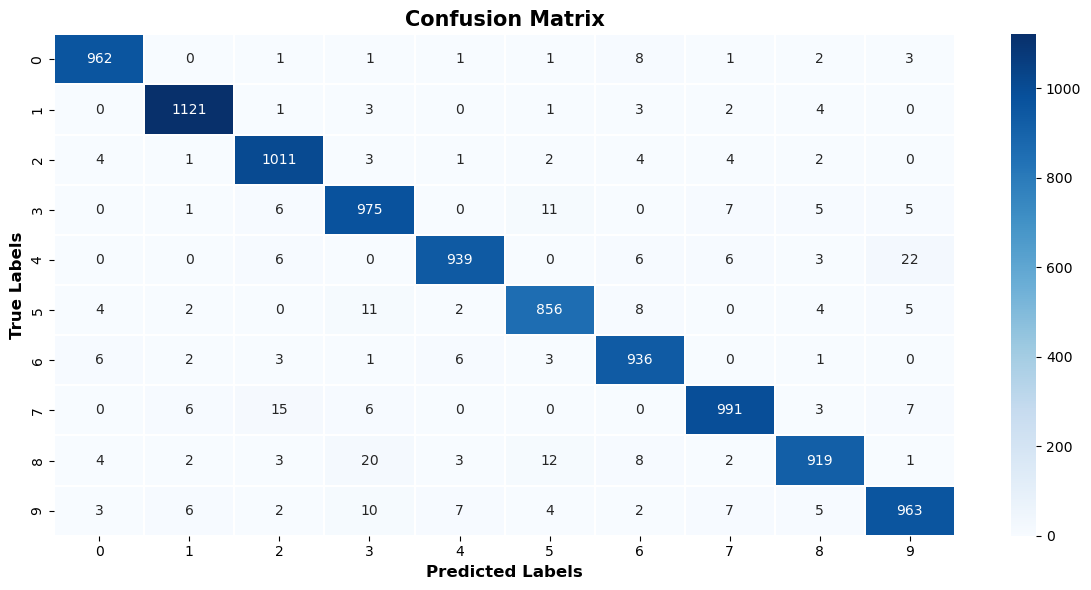

In [15]:
# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.2)
plt.xlabel("Predicted Labels", fontsize = 12, fontweight = 'bold')
plt.ylabel("True Labels", fontsize = 12, fontweight = 'bold')
plt.title("Confusion Matrix", fontsize = 15, fontweight = 'bold')
plt.tight_layout()
plt.show()